In [2]:
# do imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string 
import nltk 
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [4]:
# Scrape Tweets

import snscrape.modules.twitter as sntwitter
import pandas as pd

# declare variables and query
tweets_list = []
tweet_count = 1000
query = "republican since:2021-01-01 until:2022-11-13" 

# use TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i>tweet_count:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
tweets_df

,Datetime,Tweet Id,Text,Username
0,2022-11-12 23:59:59+00:00,1591581604266508288,"We were warned 2 years ago, that Elon will get...",fredjfrancis
1,2022-11-12 23:59:57+00:00,1591581598180601856,@SenateGOP Has anyone else noticed but it’s on...,cbsky7
2,2022-11-12 23:59:56+00:00,1591581592883204096,"Lee Zeldin won Nassau County this year by 54,...",AdamAyman57
3,2022-11-12 23:59:56+00:00,1591581592589590528,I guess that McConnell preferred to see that S...,MJL9018
4,2022-11-12 23:59:55+00:00,1591581590295314432,@DanRodricks And democrats don’t? When’s the l...,JoRoge85
...,...,...,...,...
996,2022-11-12 23:40:50+00:00,1591576783941517316,"The ""base"" didn't vote for Republican candidat...",nkanow
997,2022-11-12 23:40:49+00:00,1591576782733742080,The Republican Party is starting to look like ...,ZacSwanson7
998,2022-11-12 23:40:49+00:00,1591576782209417216,@VardemanBrian @jrh22aol @DonaldJTrumpJr Typic...,BostonMichele
999,2022-11-12 23:40:49+00:00,1591576779936137216,#News: How The Midterms Diminished The #Trump ...,NewsToter


In [5]:
# clean tweets

def clean_string(a):
    
    # remove emoji's
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    a = emoji_pattern.sub(r'', a)

    # remove @ symbols and hashtags
    re_list = ['@[A-Za-z0–9_]+', '#']
    combined_re = re.compile( '|'.join( re_list) )
    a = re.sub(combined_re,'',a)

    # remove urls from text
    pattern = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')
    a = re.sub(pattern,'',a)
    output = a
    return output

length = len(tweets_df)

# clean tweets with function we wrote above
df = tweets_df
for i in range(length):
    df['Text'][i] = clean_string(df.iloc[i]['Text'])
    
for i in range(5):
    output = df.iloc[i]['Text']
    print(output)
    print('\n')


We were warned 2 years ago, that Elon will get egotistical, Republican, and have no care for lives.


 Has anyone else noticed but it’s only the Republican controlled states who are constantly whining about border security.


Lee Zeldin won Nassau County this year  by 54,184 votes, 11 points. Working class voters delivered for Zeldin. This numbers are almost unheard of for a Republican. Rs gain 2 seats in Nassau.
He did better than Pataki 1994 across Long Island.
The problem is NYC and Hudson Valley 


I guess that McConnell preferred to see that Senate seat in the hands of a Democrat rather than occupied by a Trump Republican.


 And democrats don’t? When’s the last time you voted for a republican?




In [6]:
# generate word cloud

from nltk.tokenize import WordPunctTokenizer
tk = WordPunctTokenizer()

def tokenize_and_process(d):
    
    d = str(d)
    lower_case = d.lower()
    words = tk.tokenize(lower_case)
    result_words = [x for x in words if len(x) > 2]
    return (" ".join(result_words)).strip()

processed_tweets = []
level = int(length/10)
print ('Processsing and tokenizing tweets')
for i in range(length):
    if i % level == 0:
        print("Tweets {} of {} have been processed".format(i, length))
    processed_tweets.append(tokenize_and_process(df.Text[i]))
    
    
string = pd.Series(processed_tweets).str.cat(sep=' ')

Processsing and tokenizing tweets
Tweets 0 of 1001 have been processed
Tweets 100 of 1001 have been processed
Tweets 200 of 1001 have been processed
Tweets 300 of 1001 have been processed
Tweets 400 of 1001 have been processed
Tweets 500 of 1001 have been processed
Tweets 600 of 1001 have been processed
Tweets 700 of 1001 have been processed
Tweets 800 of 1001 have been processed
Tweets 900 of 1001 have been processed
Tweets 1000 of 1001 have been processed


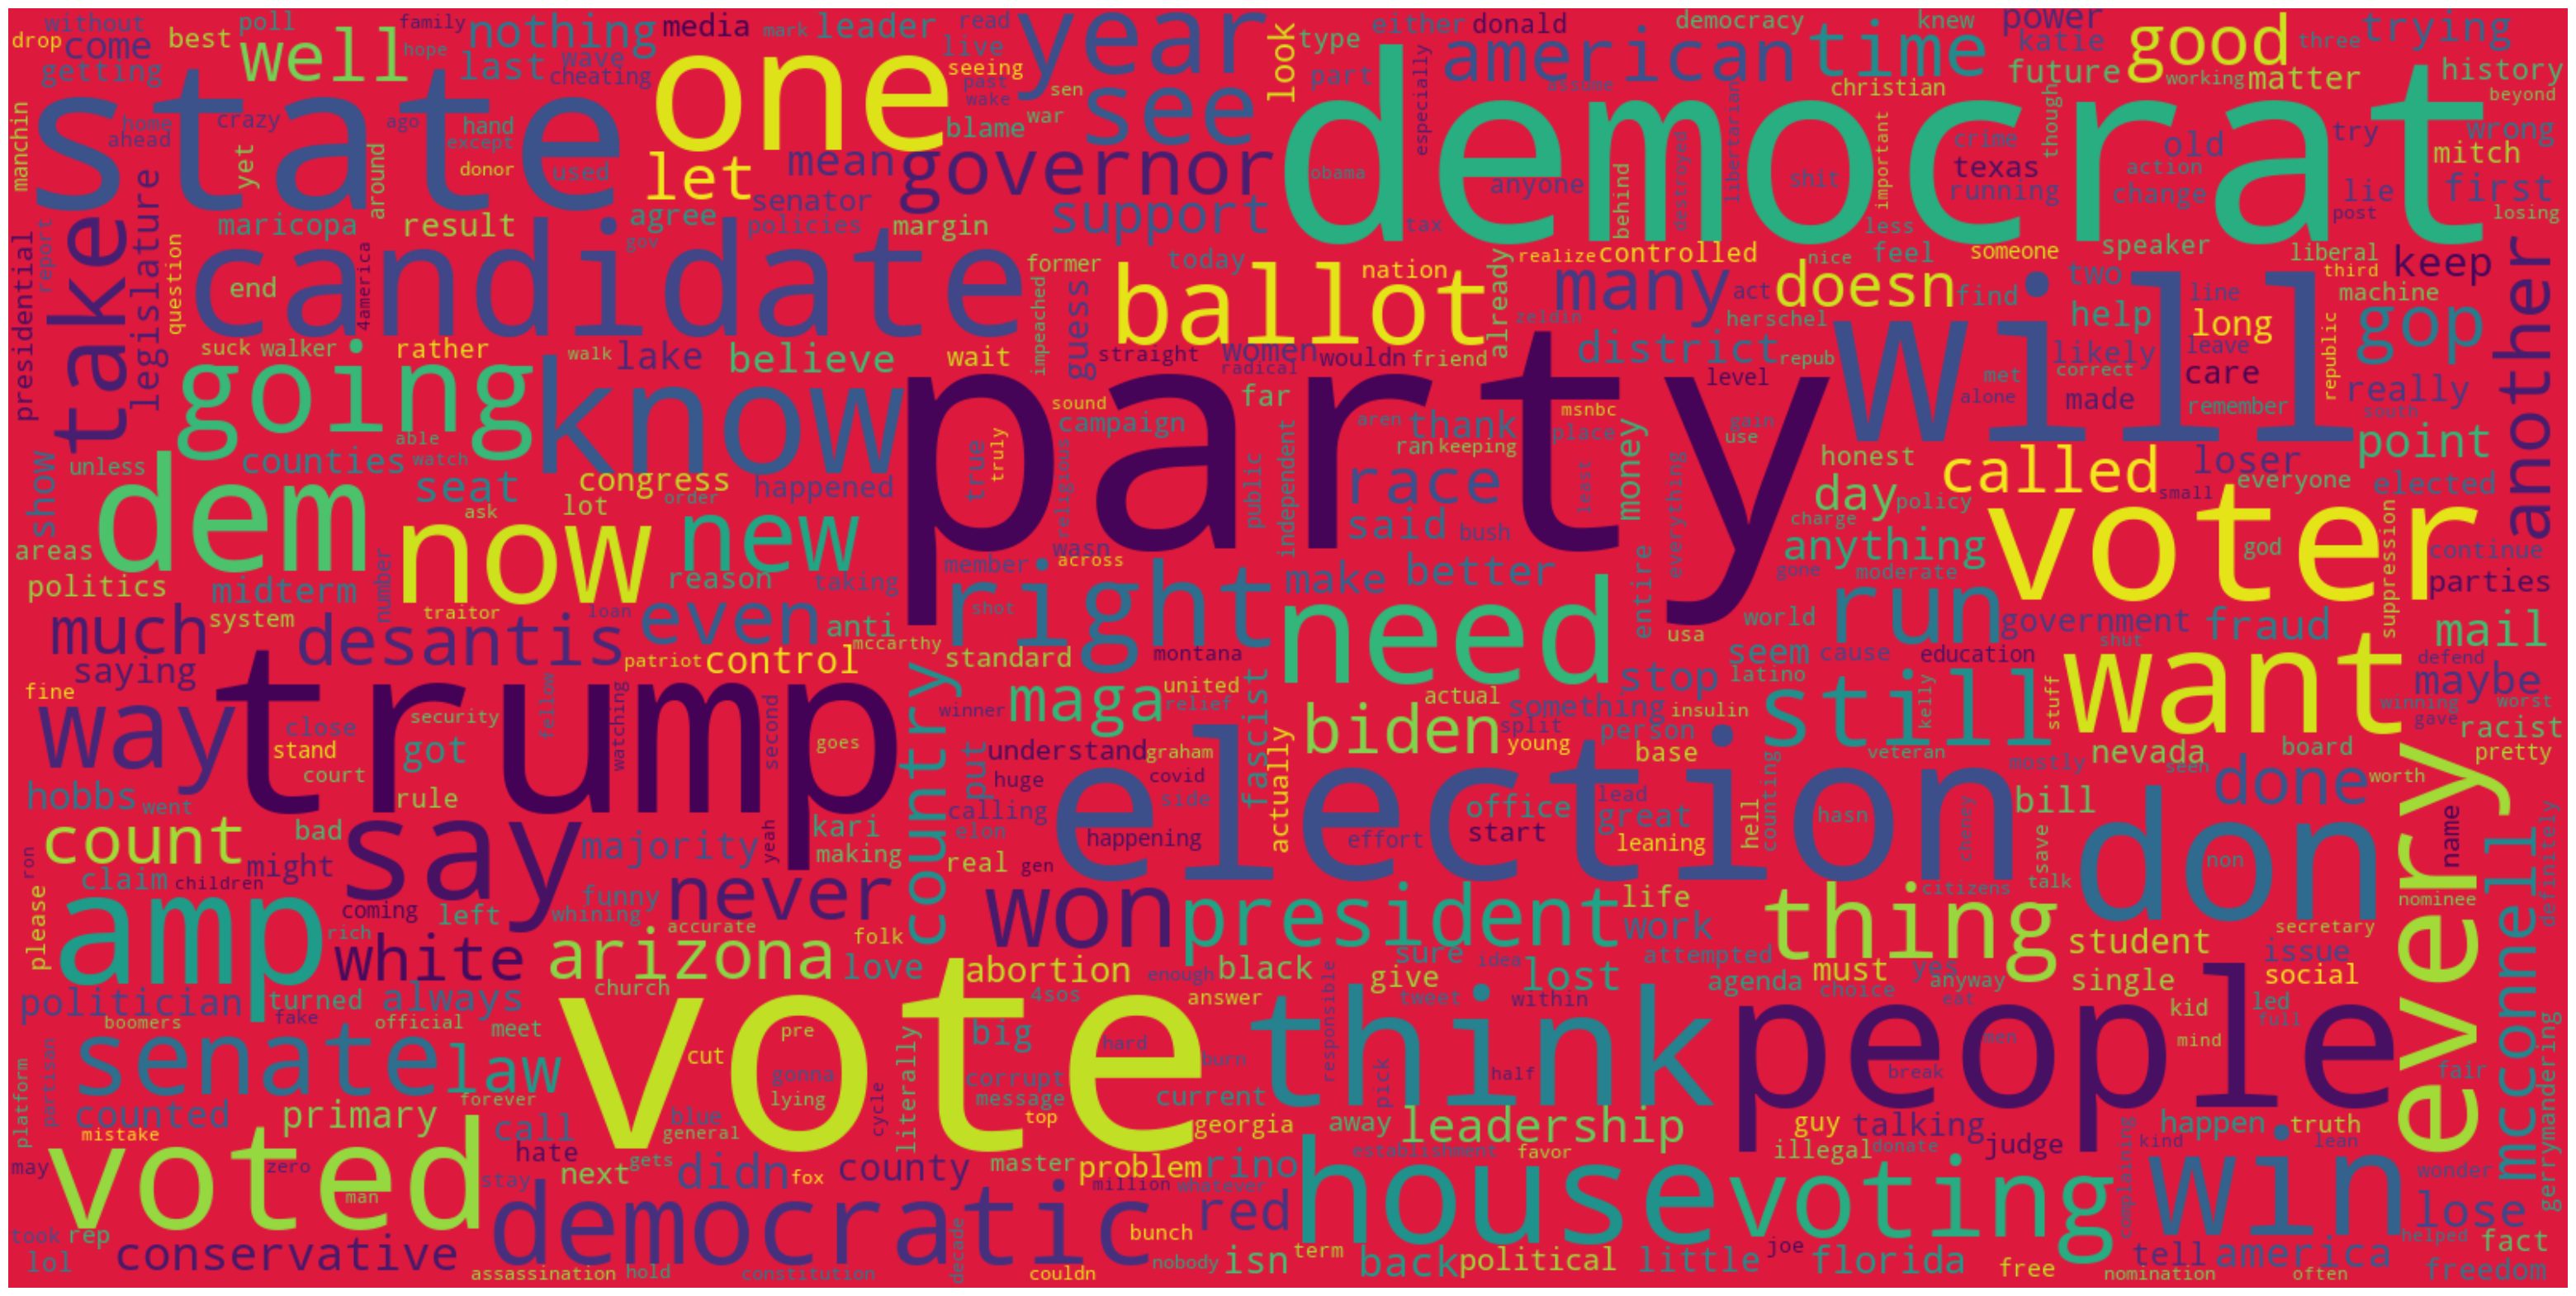

In [13]:
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
custom_stopwords = ['republican','republicans']
stopwords.update(custom_stopwords)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=500,collocations=False, background_color='#de193e').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### BERT Model

In [9]:
!pip install transformers requests beautifulsoup4 pandas numpy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
import re

In [10]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')


In [11]:
tokens = tokenizer.encode('I Love', return_tensors='pt')
result = model(tokens)
result.logits
int(torch.argmax(result.logits))+1


5

In [12]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [13]:
test = df.iloc[0]['Text']
test

'We were warned 2 years ago, that Elon will get egotistical, Republican, and have no care for lives.'

In [14]:
sentiment_score(test)

1

In [15]:
df['sentiment'] = df['Text'].apply(lambda x: sentiment_score(x[:512]))


Text(0, 0.5, 'Frequency')

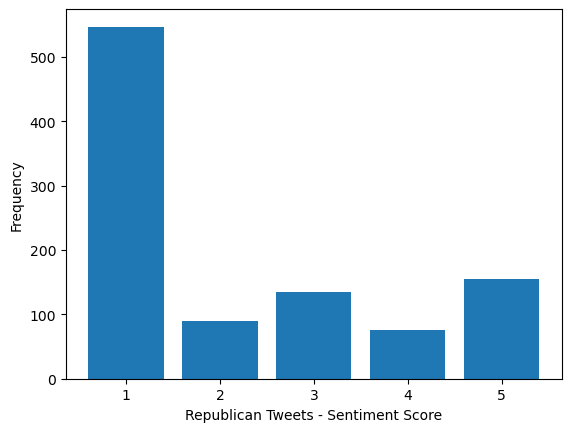

In [18]:
import matplotlib.pyplot as plt

a = df['sentiment'].value_counts()
y = [a[1],a[2],a[3],a[4],a[5]]
x = [1,2,3,4,5]
plt.bar(x,y)

plt.xlabel("Republican Tweets - Sentiment Score")
plt.ylabel("Frequency")

In [17]:
y

[547, 90, 134, 75, 155]

Text(0, 0.5, 'Frequency')

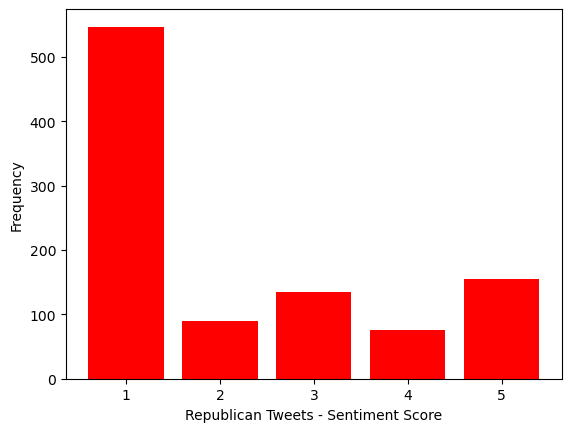

In [17]:
import matplotlib.pyplot as plt

y = [547, 90, 134, 75, 155]
x = [1,2,3,4,5]
plt.bar(x,y,color='red')

plt.xlabel("Republican Tweets - Sentiment Score")
plt.ylabel("Frequency")